C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[ 0.32510349 -0.25660011 -1.          0.035633  ]


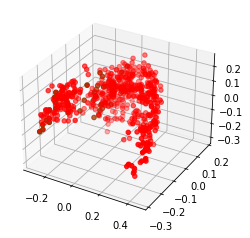

In [1]:
from __future__ import division
from scipy.spatial.distance import euclidean
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def matrix_group(group, pcoa):
    ''' 
        Fässt die Koordinaten der Gruppe in einer Matrix zusammen.
    '''
    arr = np.empty((0,3), int)
    #Wenn Sample in Gruppe ist, füge Koordinaten dem Array hinzu:
    for row in pcoa.index:
        if any(True for val in group['sample_name'] if val == pcoa['id'][row]):
            axis1 = pcoa['axis1'][row]
            axis2 = pcoa['axis2'][row]
            axis3 = pcoa['axis3'][row]
            arr = np.append(arr, np.array([[axis1,axis2,axis3]]), axis=0)
    return arr


#Berechne Koordinaten der Healthy Plane
#Aus Studie übernommen
def compute_coefficients(xyz):
    """Fit a plane to the first three dimensions of a matrix

    Parameters
    ----------
    xyz : array-like
        The matrix of data to fit the plane to.

    Returns
    -------
    np.array
        1-dimensional array with four values, the coefficients `a`, `b`, `c`
        and `d` in the equation:

    .. math::
        a\ x + b\ y - c\ z + d = 0.

    """
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]

    A = np.column_stack([x, y, np.ones_like(x)])
    abd, residuals, rank, s = np.linalg.lstsq(A, z)

    # add the coefficient of Z to
    return np.insert(abd, 2, -1)


if __name__ == "__main__":
    #Ergebnisse der PCoA einlesen
    pcoa = pd.read_csv('coordinates.txt', sep='\t')
    
    #Metadaten einlesen
    df = pd.read_csv("NIHMS841832-supplement-1.csv", sep=',')

    #Healthy Control
    HC = df[df.ibd_subtype.eq("HC")]
    HC_matrix = matrix_group(HC,pcoa)
    
    #CCD
    CCD = df[df.ibd_subtype.eq("CCD")]
    CCD_matrix = matrix_group(CCD, pcoa)
    
    #ICD-r
    ICD_r = df[df.ibd_subtype.eq("ICD_r")]
    ICD_r_matrix = matrix_group(ICD_r, pcoa)
        
    #ICD-nr
    ICD_nr = df[df.ibd_subtype.eq("ICD_nr")]
    ICD_nr_matrix = matrix_group(ICD_nr, pcoa)
    
    #UCD
    UC = df[df.ibd_subtype.eq("UC")]
    UC_matrix = matrix_group(UC, pcoa)
   
    coef =  compute_coefficients(HC_matrix)
    
    a = coef[0]
    b = coef[1]
    c = coef[2]
    d = coef[3]
    

    normal = np.array([a, b, c])
    
    # create x,y
    xx, yy = np.meshgrid(range(5), range(5))
    # calculate corresponding z
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    # plot the surface
    plt3d = plt.figure().gca(projection='3d')
   # plt3d.plot_surface(xx, yy, z)
      
    #Gesunde Punkte
    xWerte = [i[0] for i in HC_matrix]
    yWerte = [i[1] for i in HC_matrix]
    zWerte = [i[2] for i in HC_matrix]
   # plt3d.add_subplot(111, projection='3d')
    plt3d.scatter(xWerte, yWerte, zWerte, color='green')
    
    
    xRest = [pcoa['axis1']]
    yRest = [pcoa['axis2']]
    zRest = [pcoa['axis3']]
   # plt3d.add_subplot(111, projection='3d')
    plt3d.scatter(xRest, yRest, zRest, color='red')

  
    
    
    

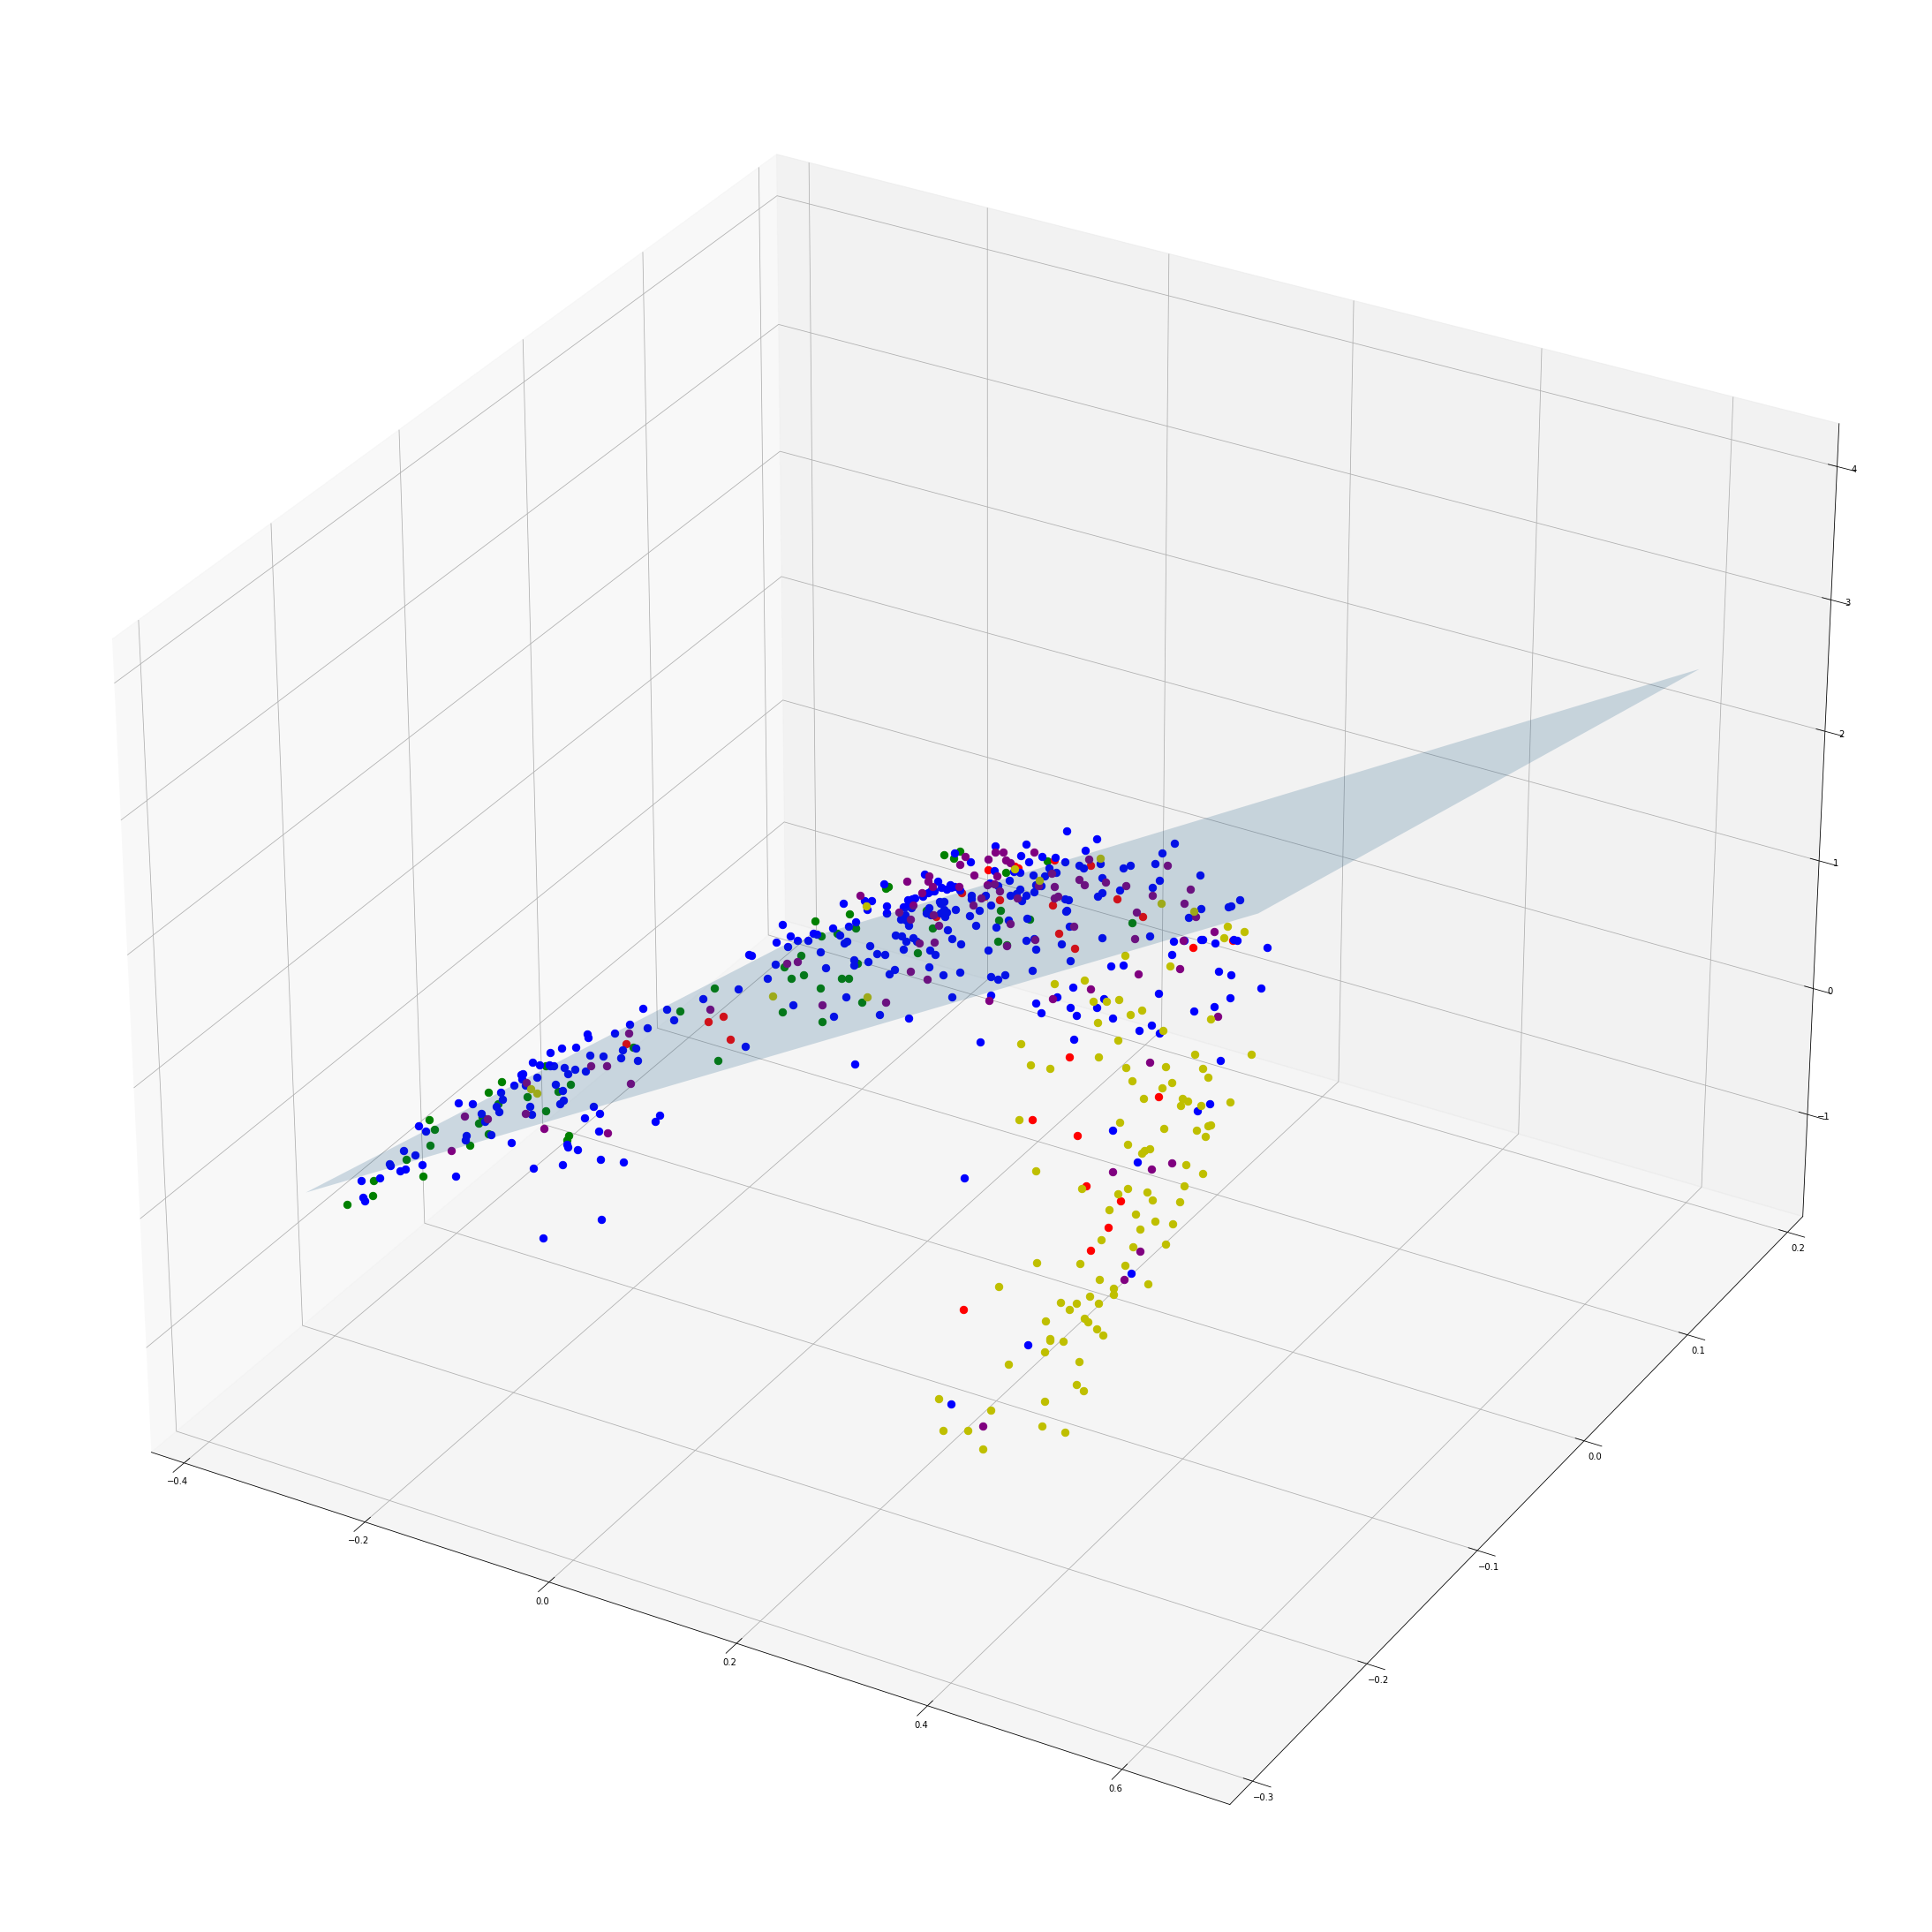

In [2]:
from skspatial.objects import Points, Plane
from skspatial.plotting import plot_3d

pointsHC = Points(HC_matrix)
pointsICD_r = Points(ICD_r_matrix)
pointsICD_nr = Points(ICD_nr_matrix)
pointsCCD = Points(CCD_matrix)
pointsUC = Points(UC_matrix)


plane = Plane.best_fit(pointsHC)
fig, ax = plot_3d(
    pointsHC.plotter(c='g', s=70, depthshade=False),
    pointsICD_r.plotter(c='y', s=70, depthshade=False),
    pointsICD_nr.plotter(c='r', s=70, depthshade=False),
    pointsCCD.plotter(c='purple', s=70, depthshade=False),
    pointsUC.plotter(c='b', s=70, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-0.2,0.8), lims_y=(-0.2,0.2)),
)

fig.set_size_inches(40, 40)
plt.savefig('Plane.png')
plt.show()




In [3]:
print(coef)


[ 0.32510349 -0.25660011 -1.          0.035633  ]
